In [1]:
# results obtained from E1
degree = 3
compression_rate = 0.3
eps = 1e-7

In [2]:
%%time
from utils.data import load_ucr_dataset, load_ucr_data_short_and_medium, load_gbnc_data

# load data
data = load_ucr_data_short_and_medium()
#data = load_ucr_dataset(53)
#data = load_gbnc_data()
print("number of time series:", len(data.index))


number of time series: 135
CPU times: total: 250 ms
Wall time: 341 ms


In [3]:
from utils.plot import add_fitted_curve_to_plot
import numpy as np


def fit_spline(method: str, ts: [(float, float)], knots: [float], num_coeffs: int, num_outliers_removed: int,
               degree=None, plot=False, axis=None):
    match method:
        case 'PAA':
            color = 'tab:gray'
            degree = 0
            _, result = fit_max_spline(ts, knots, degree)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

        case 'PLA':
            color = 'tab:olive'
            degree = 1
            _, result = fit_max_spline(ts, knots, degree)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

        case 'L8':
            color = 'tab:pink'
            if degree is None:
                degree = 3

            _, result = fit_max_spline(ts, knots, degree)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

        case 'L8 and L1':
            color = 'tab:blue'
            if degree is None:
                degree = 3

            _, result = fit_max_l1_spline(ts, knots, degree, eps=eps)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

        case 'DFT':
            color = 'tab:green'
            result = fit_DFT(ts, num_coeffs)
            fitted_curve = calculate_inverse_DFT(len(ts), num_coeffs, result)

        case 'LSQ':
            color = 'tab:purple'
            if degree is None:
                degree = 3

            if num_outliers_removed > 0:
                num_xs = len(ts) + num_outliers_removed

                num_coeffs = generate_coeff_counts(num_xs, degree, [compression_rate])[0]
                knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=num_coeffs)

                # Alternative 1 num_coeff Ausreißer (s.u.)
                """knots = generate_knot_vector_from_coeff_count(degree=degree,
                                                              num_coeffs=num_coeffs + num_outliers_removed)"""

                # Alternative 2 (einfach neue Berechnung weglassen)

                xs = np.linspace(0, 1, num=num_xs)
                ts = replace_outliers(ts_without_outliers=ts, original_xs=xs)

            result = fit_LSQ_spline(time_series=ts, knots=knots, degree=degree)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

    max_dist = np.max(np.abs(np.array(fitted_curve) - np.array([x[1] for x in ts])))
    mse = mean_squared_error(fitted_curve, [x[1] for x in ts])
    mae = mean_absolute_error(fitted_curve, [x[1] for x in ts])

    if plot:
        if axis is not None:
            add_fitted_curve_to_plot(axis, [x[0] for x in ts], fitted_curve, max_dist, color=color, label=method)
        else:
            add_fitted_curve_to_plot(plt, [x[0] for x in ts], fitted_curve, max_dist, color=color, label=method)


    return {'max_dist': max_dist,
            'MSE': mse,
            'MAE': mae}


# OHNE AUSREISSER, OHNE PLOTS

In [4]:
"""%%time
from tsfel import mean_diff
from utils.data import remove_outliers, replace_outliers
from utils.spline import generate_coeff_counts, generate_knot_vector_from_coeff_count
from utils.fit import fit_max_spline, fit_max_l1_spline, fit_DFT, calculate_inverse_DFT, fit_LSQ_spline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.spline import evaluate_spline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

results = []
num_rows = len(data.index)
ts_properties = []

for idx, row in data.iterrows():

    ts = row['data']
    print(f"{row['dataset']} no. {row['num']}, {round(idx / num_rows * 100, 1)}% processed")

    ts_properties.append({
        'dataset': row['dataset'],
        'num': row['num'],
        'num_data_pts': len(ts),
        'num_outliers_removed': 0,
        'mean_diff': mean_diff(ts),
        'max_fst_derivative': max(pd.Series([tup[0] for tup in ts]).diff().dropna()),
        'max_snd_derivative': max(pd.Series([tup[0] for tup in ts]).diff().diff().dropna())
    })

    num_coeffs = generate_coeff_counts(len(ts), degree, compression_ratios=[compression_rate])[0]
    knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=num_coeffs)

    for method in ['L8', 'L8 and L1', 'LSQ', 'PAA', 'PLA', 'DFT']:
        metrics = fit_spline(method=method, ts=ts, knots=knots, num_coeffs=num_coeffs, num_outliers_removed=0,
                             degree=degree)

        results.append({
            'dataset': row['dataset'],
            'num': row['num'],
            'num_data_pts': len(ts),
            'num_outliers_removed': 0,
            'num_coeffs': num_coeffs,
            'method': method,
            'max_dist': metrics['max_dist'],
            'MSE': metrics['MSE'],
            'MAE': metrics['MAE']
        })"""


'%%time\nfrom tsfel import mean_diff\nfrom utils.data import remove_outliers, replace_outliers\nfrom utils.spline import generate_coeff_counts, generate_knot_vector_from_coeff_count\nfrom utils.fit import fit_max_spline, fit_max_l1_spline, fit_DFT, calculate_inverse_DFT, fit_LSQ_spline\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error\nfrom utils.spline import evaluate_spline\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport pandas as pd\n\nresults = []\nnum_rows = len(data.index)\nts_properties = []\n\nfor idx, row in data.iterrows():\n\n    ts = row[\'data\']\n    print(f"{row[\'dataset\']} no. {row[\'num\']}, {round(idx / num_rows * 100, 1)}% processed")\n\n    ts_properties.append({\n        \'dataset\': row[\'dataset\'],\n        \'num\': row[\'num\'],\n        \'num_data_pts\': len(ts),\n        \'num_outliers_removed\': 0,\n        \'mean_diff\': mean_diff(ts),\n        \'max_fst_derivative\': max(pd.Series([tup[0] for tup in ts]).diff().dropna()),\

# MIT AUSREISSERN, OHNE PLOTS

In [5]:
%%time
import matplotlib.pyplot as plt
from tsfel import mean_diff
from utils.data import remove_outliers, replace_outliers
from utils.spline import generate_coeff_counts, generate_knot_vector_from_coeff_count
from utils.fit import fit_max_spline, fit_max_l1_spline, fit_DFT, calculate_inverse_DFT, fit_LSQ_spline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.spline import evaluate_spline
import pandas as pd

results = []
num_rows = len(data.index)
ts_properties = []

for idx, row in data.iterrows():
    original_time_series = row['data']
    time_series_lof = remove_outliers(row['data'])
    n_outliers = len(original_time_series) - len(time_series_lof)
    print(f"{row['dataset']} no. {row['num']}, {round(idx / num_rows * 100, 1)}% processed")

    """f, axes = plt.subplots(1, 2, sharey=True)
    f.set_figwidth(12)

    axes[0].set_title("Data including outliers")
    axes[1].set_title("Data without outliers")"""

    for ts, num_outliers_removed in [(original_time_series, -1),(time_series_lof, n_outliers)]:
        #for ts in [original_time_series, time_series_lof]:
        #num_outliers_removed = len(original_time_series) - len(ts)
        #assert num_outliers_removed >= 0
        #print("len(ts):", len(ts))

        if num_outliers_removed == 0:
            continue

        ts_properties.append({
            'dataset': row['dataset'],
            'num': row['num'],
            'num_data_pts': len(ts),
            'num_outliers_removed': num_outliers_removed if num_outliers_removed >= 0 else 0,
            'mean_diff': mean_diff(ts),
            'max_fst_derivative': max(pd.Series([tup[0] for tup in ts]).diff().dropna()),
            'max_snd_derivative': max(pd.Series([tup[0] for tup in ts]).diff().diff().dropna()),
            'min_fst_derivative': min(pd.Series([tup[0] for tup in ts]).diff().dropna()),
            'min_snd_derivative': min(pd.Series([tup[0] for tup in ts]).diff().diff().dropna()),
            'avg_fst_derivative': pd.Series([tup[0] for tup in ts]).diff().dropna().mean(),
            'avg_snd_derivative': pd.Series([tup[0] for tup in ts]).diff().diff().dropna().mean()
        })

        # Alternative 1 zur Berechnung der Koeffizienten bei TS ohne Ausreißer
        #num_coeffs = generate_coeff_counts(len(original_time_series), degree, compression_ratios=[compression_rate])[0]
        #knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=(num_coeffs - num_outliers_removed))

        # Alternative 2 zur Berechnung der Koeffizienten bei TS ohne Ausreißer
        #num_coeffs = generate_coeff_counts(len(original_time_series), degree, compression_ratios=[compression_rate])[0]
        #knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=num_coeffs)

        # ursprüngliche Variante (es müssen compr_rate * n_outliers viele Punkte zusätzlich gespeichert werden)
        num_coeffs = generate_coeff_counts(len(ts), degree, compression_ratios=[compression_rate])[0]
        knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=num_coeffs)

        
        for method in ['L8', 'L8 and L1', 'LSQ', 'PAA', 'PLA', 'DFT']:
            plot_method = False
            axis = None

            """if method in ['L8', 'L8 and L1', 'LSQ', 'PAA', 'PLA', 'DFT']:
                    plot_method = True


            if num_outliers_removed > 0:
                axis = axes[1]
            else:
                axis = axes[0]"""

            metrics = fit_spline(method, ts, knots, num_coeffs, num_outliers_removed, plot=plot_method, axis=axis)

            results.append({
                'dataset': row['dataset'],
                'num': row['num'],
                'num_data_pts': len(ts),
                'num_outliers_removed': num_outliers_removed if num_outliers_removed >= 0 else 0,
                'num_coeffs': num_coeffs,
                'method': method,
                'max_dist': metrics['max_dist'],
                'MSE': metrics['MSE'],
                'MAE': metrics['MAE']
            })

        """if num_outliers_removed == -1:
            df = pd.DataFrame(results)
            current_df = df[(df['dataset']==row['dataset'])&(df['num']==row['num'])]
            print(current_df.loc[:,['method','max_dist','MSE','MAE']])"""
        #axis.scatter([d[0] for d in ts], [d[1] for d in ts], color="brown", marker='.')
    
    """plt.subplots_adjust(bottom=0.25, top=0.95)
    axes[0].legend(loc='upper right')
    axes[1].legend(loc='upper right')
    plt.tight_layout()
    plt.show()"""


GunPointMaleVersusFemale no. 0, 0.0% processed
GunPointMaleVersusFemale no. 1, 0.7% processed
GunPointMaleVersusFemale no. 2, 1.5% processed
GunPointMaleVersusFemale no. 3, 2.2% processed
GunPointMaleVersusFemale no. 4, 3.0% processed
GunPointMaleVersusFemale no. 5, 3.7% processed
GunPointMaleVersusFemale no. 6, 4.4% processed
GunPointMaleVersusFemale no. 7, 5.2% processed
GunPointMaleVersusFemale no. 8, 5.9% processed
GunPointMaleVersusFemale no. 9, 6.7% processed
GunPointMaleVersusFemale no. 10, 7.4% processed
GunPointMaleVersusFemale no. 11, 8.1% processed
GunPointMaleVersusFemale no. 12, 8.9% processed
GunPointMaleVersusFemale no. 13, 9.6% processed
GunPointMaleVersusFemale no. 14, 10.4% processed
GunPointMaleVersusFemale no. 15, 11.1% processed
GunPointMaleVersusFemale no. 16, 11.9% processed
GunPointMaleVersusFemale no. 17, 12.6% processed
GunPointMaleVersusFemale no. 18, 13.3% processed
GunPointMaleVersusFemale no. 19, 14.1% processed
GunPointMaleVersusFemale no. 20, 14.8% proce

KeyboardInterrupt: 

# EVALUATE RESULTS

In [6]:
import pandas as pd

pd.set_option('display.float_format', '{:.8f}'.format)

e2_results = pd.DataFrame(results).drop_duplicates()
mean_values = e2_results.groupby('method').agg({'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values

,method,max_dist,MSE,MAE
0,DFT,0.31041805,0.00717725,0.04386018
1,L8,0.06190474,0.00948310,0.04489141
2,L8 and L1,0.06190484,0.00381547,0.02097624
3,LSQ,0.20721183,0.00232915,0.01638182
4,PAA,0.31436680,0.11501348,0.28269721
5,PLA,0.08309158,0.01413006,0.06859637


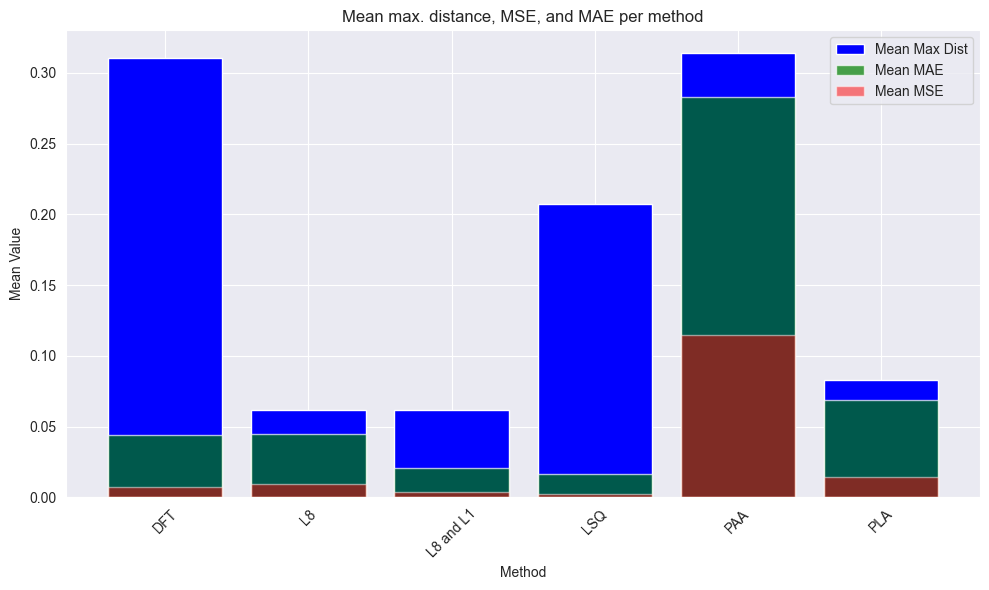

In [7]:
import matplotlib.pyplot as plt

# Plot mean values
plt.figure(figsize=(10, 6))

plt.bar(mean_values['method'], mean_values['max_dist'], color='b', label='Mean Max Dist')
plt.bar(mean_values['method'], mean_values['MAE'],alpha=0.7, color='g', label='Mean MAE')
plt.bar(mean_values['method'], mean_values['MSE'], alpha=0.5,color='r', label='Mean MSE')
plt.xlabel('Method')
plt.ylabel('Mean Value')
plt.title('Mean max. distance, MSE, and MAE per method')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
"""
import pandas as pd
pd.set_option('display.float_format', '{:.8f}'.format)

# Calculate mean values for each accuracy measure separately
mean_max_dist = e2_results.groupby('method')['max_dist'].mean().reset_index()
mean_mse = e2_results.groupby('method')['MSE'].mean().reset_index()
mean_mae = e2_results.groupby('method')['MAE'].mean().reset_index()

# Merge the mean values into a single DataFrame
mean_values = mean_max_dist.merge(mean_mse, on='method').merge(mean_mae, on='method')
mean_values"""

"\nimport pandas as pd\npd.set_option('display.float_format', '{:.8f}'.format)\n\n# Calculate mean values for each accuracy measure separately\nmean_max_dist = e2_results.groupby('method')['max_dist'].mean().reset_index()\nmean_mse = e2_results.groupby('method')['MSE'].mean().reset_index()\nmean_mae = e2_results.groupby('method')['MAE'].mean().reset_index()\n\n# Merge the mean values into a single DataFrame\nmean_values = mean_max_dist.merge(mean_mse, on='method').merge(mean_mae, on='method')\nmean_values"

In [9]:
# combine results df with ts properties df for analysis later
ts_props = pd.DataFrame(ts_properties).drop_duplicates()
e2 = pd.merge(e2_results, ts_props, how='left', on=['dataset', 'num', 'num_data_pts', 'num_outliers_removed'])
e2

,dataset,num,num_data_pts,num_outliers_removed,num_coeffs,method,max_dist,MSE,MAE,mean_diff,max_fst_derivative,max_snd_derivative,min_fst_derivative,min_snd_derivative,avg_fst_derivative,avg_snd_derivative
0,GunPointMaleVersusFemale,0,150,0,45,L8,0.03200419,0.00059160,0.02226643,-0.50000000,0.00671141,0.00000000,0.00671141,-0.00000000,0.00671141,-0.00000000
1,GunPointMaleVersusFemale,0,150,0,45,L8 and L1,0.03200429,0.00028509,0.01175898,-0.50000000,0.00671141,0.00000000,0.00671141,-0.00000000,0.00671141,-0.00000000
2,GunPointMaleVersusFemale,0,150,0,45,LSQ,0.04051147,0.00009659,0.00552338,-0.50000000,0.00671141,0.00000000,0.00671141,-0.00000000,0.00671141,-0.00000000
3,GunPointMaleVersusFemale,0,150,0,45,PAA,0.25907665,0.05672287,0.22993348,-0.50000000,0.00671141,0.00000000,0.00671141,-0.00000000,0.00671141,-0.00000000
4,GunPointMaleVersusFemale,0,150,0,45,PLA,0.05102615,0.00200093,0.04239775,-0.50000000,0.00671141,0.00000000,0.00671141,-0.00000000,0.00671141,-0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,GunPointMaleVersusFemale,40,150,0,45,L8 and L1,0.40429152,0.04362583,0.13837720,-0.50000000,0.00671141,0.00000000,0.00671141,-0.00000000,0.00671141,-0.00000000
482,GunPointMaleVersusFemale,40,150,0,45,LSQ,0.57448410,0.00503129,0.02686752,-0.50000000,0.00671141,0.00000000,0.00671141,-0.00000000,0.00671141,-0.00000000
483,GunPointMaleVersusFemale,40,150,0,45,PAA,0.89769111,0.73551043,0.85163467,-0.50000000,0.00671141,0.00000000,0.00671141,-0.00000000,0.00671141,-0.00000000
484,GunPointMaleVersusFemale,40,150,0,45,PLA,0.44929510,0.13958882,0.35546606,-0.50000000,0.00671141,0.00000000,0.00671141,-0.00000000,0.00671141,-0.00000000


# comparison: outliers vs. no outliers (for each method)

In [10]:
df_no_outliers = e2[e2['num_outliers_removed'] > 0]
df_with_outliers = e2[e2['num_outliers_removed'] == 0]
#df_no_outliers = e2_results[e2_results['num_outliers_removed'] > 0]
#df_with_outliers = e2_results[e2_results['num_outliers_removed'] == 0]

mean_values_no_outliers = df_no_outliers.groupby('method').agg(
    {'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values_no_outliers.rename(columns={'max_dist': 'max_dist w/o o.', 'MSE': 'MSE w/o o.', 'MAE': 'MAE w/o o.'},
                               inplace=True)

mean_values_with_outliers = df_with_outliers.groupby('method').agg(
    {'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values_with_outliers.rename(columns={'max_dist': 'max_dist', 'MSE': 'MSE', 'MAE': 'MAE'}, inplace=True)

mean_values_combined = pd.merge(mean_values_with_outliers, mean_values_no_outliers, on='method', how='outer')
mean_values_combined

,method,max_dist,MSE,MAE,max_dist w/o o.,MSE w/o o.,MAE w/o o.
0,DFT,0.14066277,0.00100418,0.00929148,0.48441722,0.01350464,0.07929310
1,L8,0.09809262,0.01802102,0.07204654,0.02481217,0.00073173,0.01705741
2,L8 and L1,0.09809272,0.00717629,0.03242298,0.02481227,0.00037063,0.00924333
3,LSQ,0.14038797,0.00101470,0.00799084,0.27570629,0.00367646,0.02498259
4,PAA,0.40800337,0.18102451,0.36843408,0.21838931,0.04735217,0.19481692
5,PLA,0.12035156,0.02561226,0.09945150,0.04490009,0.00236079,0.03696987


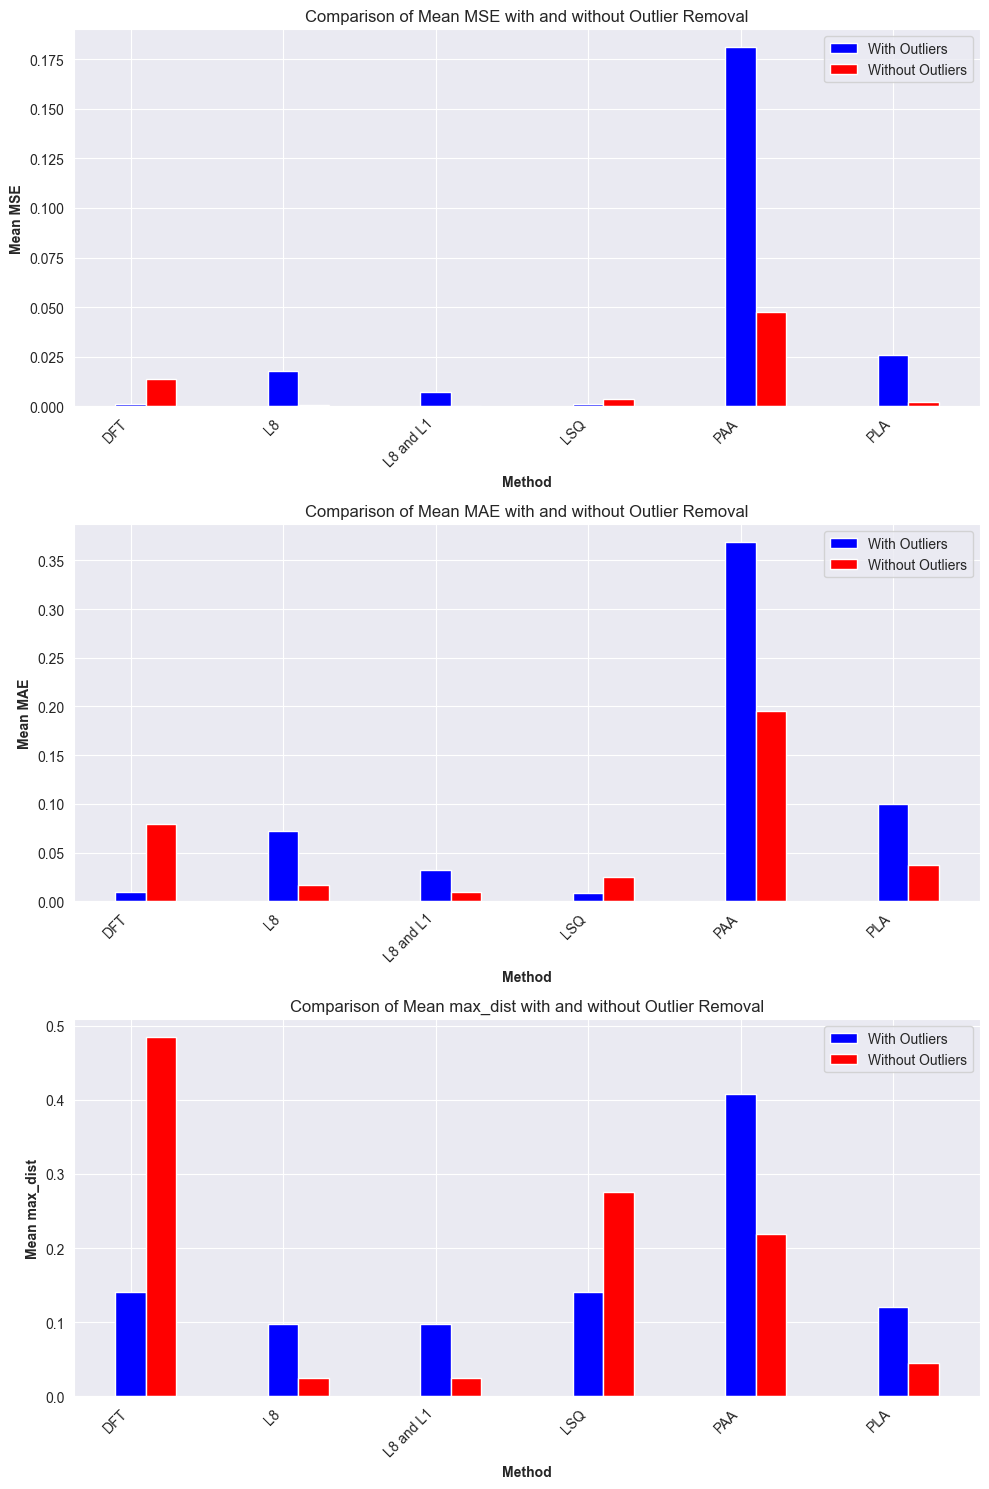

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual mean accuracy values)
methods = mean_values_combined['method']
metrics = ['MSE', 'MAE', 'max_dist']

# Set the width of the bars
bar_width = 0.2
num_methods = len(methods)
r = np.arange(num_methods)

# Create subplots for each accuracy measure
fig, axs = plt.subplots(len(metrics), figsize=(10, 15))

for i, metric in enumerate(metrics):
    metric_with_outliers = mean_values_combined[metric]
    metric_without_outliers = mean_values_combined[f'{metric} w/o o.']

    # Set the position of the bars for each accuracy measure
    r1 = r + bar_width/2
    r2 = [x + bar_width for x in r1]

    # Create the bar plots for each accuracy measure
    axs[i].bar(r1, metric_with_outliers, color='b', width=bar_width, label='With Outliers')
    axs[i].bar(r2, metric_without_outliers, color='r', width=bar_width, label='Without Outliers')

    # Add labels and title
    axs[i].set_xlabel('Method', fontweight='bold')
    axs[i].set_ylabel(f'Mean {metric}', fontweight='bold')
    axs[i].set_xticks([r + bar_width/2 for r in range(num_methods)])
    axs[i].set_xticklabels(methods, rotation=45, ha='right')
    axs[i].set_title(f'Comparison of Mean {metric} with and without Outlier Removal')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()
